### Juice analysis is displayed here
#### Analysis for every discharge
- max. and average intensities of spectral lines (from AEF and AEI spectrometers)
- line ratios based on these intensities
- radiation fronts from the AEI view (only IP320_3 gives reliable data)
- strikelines from AEF views
#### Analysis for special discharges
- Line ratio analysis fitted to strikelines (multiple for standard for example)
- stark broadening for 


In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import importlib
import os
import logging
logging.basicConfig(level=logging.CRITICAL, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger("divertor_spectroscopy")
logger.setLevel(logging.DEBUG)

from w7xdia import extractor

from divertor_spectroscopy import qss_juice
from divertor_spectroscopy import utilities as utils


fontsize = 14
plt.rcParams.update({'font.size': fontsize})
ground_path = "//share.ipp-hgw.mpg.de/documents/frhe/Documents/phd/"

### Here is the big juice from Valeria
- sooner or later the qss should contribute here somehow
    - for this the processed data needs to be written to the archive so we can squeeze this properly

In [2]:
juice_filename = "adb_juice_op12b_step_0.20_v20210217.csv"
path = "//share.ipp-hgw.mpg.de/documents/frhe/Documents/phd/qss_analysis/discharges/OP1.2b/Juice/"+juice_filename
juice = pd.read_csv(path,  index_col=0) 

#Define things we can plot on any axes
new_collumn = []
for i,time in enumerate(juice.index):
    new_collumn.append(0.2*i)
juice["plasma_exposure_time"] = new_collumn
#Define things we can plot on any axes
plasma_exposure_time = {'label':"Plasma exposure time [s]", 'data':juice['plasma_exposure_time'], 'min':0.0, 'max':1000000}
time_inshot = {'label':"Time from t1 [s]", 'data':juice['t_in_shot'], 'min':0.0, 'max':200}
pRad = { 'label':"P$_{rad}$ [MW]", 'data':juice['prad_hbc_MW'], 'min':0, 'max':7}
power = {'label':"P$_{ECRH}$ [MW]", 'data':juice['ecrh_total_MW'], 'min':0, 'max': 7}
power_nbi = {'label':"P$_{NBI}$ [MW]", 'data':np.nan_to_num(juice["nbi_total_MW"])*0.8, 'min':0, 'max': 7}
total_power = {'label':"P$_{total}$ [MW]", 'data':juice['ecrh_total_MW']+np.nan_to_num(juice["nbi_total_MW"])*0.8, 'min':0, 'max': 10}
pFraction = { 'label':"$P_{rad}/P_{heat}$", 'data':juice['prad_hbc_MW']/total_power["data"], 'min':0, 'max':1.8}
control_coil_operation = {"label":"control coils operation","data":juice["shot_with_control_coils"],"min":0,"max":1}
control_coil_current = {"label":"Control Coil Current [kA]","data":juice["coil_control_1_kA"],"min":-2.5,"max":+2.5}
lineDensity = {'label':"Line integrated n$_e$ [$10^{19}$ m$^{-2}$]", 'data':juice['neL_1e19_m2'], 'min':0, 'max': 17}
Ip = {'label':"Ip", 'data':juice['ip_kA'], 'min':0, 'max': 8}


c:\Users\frhe\AppData\Local\anaconda3\envs\qss\lib\site-packages\IPython\core\interactiveshell.py:3553: DtypeWarning: Columns (41,42,43,44,91,120,200,219,259,337,338,339,341,349) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
boronizations = ["20180804","20180901","20180929"]
plasma_exposure_times_of_boronizations = []
for boronization in boronizations:
    for i,shot in enumerate(juice["shot"]):
        if int(boronization) < int(shot[3:11]):
            print(shot[3:11])
            plasma_exposure_times_of_boronizations.append(np.array(plasma_exposure_time["data"])[i])
            # leave loop
            break
print(plasma_exposure_times_of_boronizations)

20180807
20180904
20181002
[3848.4, 7152.0, 11074.0]


### Current QSS Juice will be created in the following cells
#### Multiple methods for Juice are implemented and every single one shall have the following structure here:
- A cell with an optional example to see how the data looks in a single discharge
- A cell that creates or reads the juice from cache for a set of discharges

### Most standard method: Reading maximum intensity per strikeline from the automatically produced 2D fitted spectra

In [4]:
if False:
    importlib.reload(qss_juice)
    shotname = "20230330.068"
    strikeline = "vertical"
    debug = True
    debug_parameters = ["Intensity_HeI_402.621", "Intensity_HI_410.173"]
    #debug_parameters = None
    intensities,description = qss_juice.get_qss_max_intensities(shotname=shotname,average="25",version="2",strikeline=strikeline,debug=debug,debug_parameters=debug_parameters)

In [5]:
if False:
    load_from_cache = True
    importlib.reload(qss_juice)
    shots = juice["shot"].str.split("W7X").str[1].unique().tolist() # all shots according to valerias Juice
    path = "//share.ipp-hgw.mpg.de/documents/frhe/Documents/phd/qss_analysis/discharges/OP2.1/intensity_overview/Data/qss_max_intensities_horizontal_juice_op21_step_0.2.csv"
    if load_from_cache:
        juice_qss_max_intensities_horizontal = pd.read_csv(path,  index_col=0) 
    else:
        importlib.reload(qss_juice)
        juice_qss_max_intensities_horizontal = extractor.squeeze_shots(shots, time_step = 0.2,  modules = [qss_juice.squeeze_qss_max_intensities],
                                                                    module_settings={"strikeline":"horizontal","central_wavelengths":["364","405"],
                                "camids":["IP320_1","IP320_2"],"port":"AEF51","average":"200","version":"1"})
        juice_qss_max_intensities_horizontal = juice_qss_max_intensities_horizontal.drop(index=juice_qss_max_intensities_horizontal.index.difference(juice.index))
        juice_qss_max_intensities_horizontal.to_csv(path)
    path = "//share.ipp-hgw.mpg.de/documents/frhe/Documents/phd/qss_analysis/discharges/OP2.1/intensity_overview/Data/qss_max_intensities_vertical_juice_op21_step_0.2.csv"
    if load_from_cache:
        juice_qss_max_intensities_vertical = pd.read_csv(path,  index_col=0) 
    else:
        importlib.reload(qss_juice)
        juice_qss_max_intensities_vertical = extractor.squeeze_shots(shots, time_step = 0.2,  modules = [qss_juice.squeeze_qss_max_intensities],
                                                                    module_settings={"strikeline":"vertical","central_wavelengths":["364","405"],
                                "camids":["IP320_1","IP320_2"],"port":"AEF51","average":"200","version":"1"})
        juice_qss_max_intensities_vertical = juice_qss_max_intensities_vertical.drop(index=juice_qss_max_intensities_vertical.index.difference(juice.index))
        juice_qss_max_intensities_vertical.to_csv(path)

    # First the overall stuff
    fit_parameters = []
    for element in list(juice_qss_max_intensities_horizontal.columns):
        if "qss_max_intensities_" in element:
            fit_parameters.append(element.split("qss_max_intensities_")[1])
    for name in fit_parameters:
        globals()["qss_max_intensities_horizontal_{}".format(name.replace(".","_"))] = {"label":"QSS max {}".format(name),"data":juice_qss_max_intensities_horizontal["qss_max_intensities_{}".format(name)],
                                                        "min":np.nanmin(juice_qss_max_intensities_horizontal["qss_max_intensities_{}".format(name)]),
                                                        "max":np.nanmax(juice_qss_max_intensities_horizontal["qss_max_intensities_{}".format(name)])}
        globals()["qss_max_intensities_vertical_{}".format(name.replace(".","_"))] = {"label":"QSS max {}".format(name),"data":juice_qss_max_intensities_vertical["qss_max_intensities_{}".format(name)],
                                                        "min":np.nanmin(juice_qss_max_intensities_vertical["qss_max_intensities_{}".format(name)]),
                                                        "max":np.nanmax(juice_qss_max_intensities_vertical["qss_max_intensities_{}".format(name)])}
    if True:
        line_ratio_horizontal_neII1 = {"label":"Neon line ratio 357.1 / 371.3","data":qss_max_intensities_horizontal_Intensity_NeII_357_111["data"]/qss_max_intensities_horizontal_Intensity_NeII_371_315["data"], 'min':0, 'max': 1}
        line_ratio_horizontal_neII2 = {"label":"Neon line ratio 371.3 / 371.7","data":qss_max_intensities_horizontal_Intensity_NeII_371_315["data"]/qss_max_intensities_horizontal_Intensity_NeII_371_755["data"], 'min':0, 'max': 1}
        line_ratio_vertical_neII1 = {"label":"Neon line ratio 357.1 / 371.3","data":qss_max_intensities_vertical_Intensity_NeII_357_111["data"]/qss_max_intensities_vertical_Intensity_NeII_371_315["data"], 'min':0, 'max': 1}
        line_ratio_vertical_neII2 = {"label":"Neon line ratio 371.3 / 371.7","data":qss_max_intensities_vertical_Intensity_NeII_371_315["data"]/qss_max_intensities_vertical_Intensity_NeII_371_755["data"], 'min':0, 'max': 1}
        line_ratio_vertical_nII = {"label":"Nitrogen line ratio 404.1 / 399.5","data":qss_max_intensities_vertical_Intensity_NII_404_098["data"]/qss_max_intensities_vertical_Intensity_NII_399_500["data"], 'min':0, 'max': 1}
        line_ratio_horizontal_nII = {"label":"Nitrogen line ratio 404.1 / 399.5","data":qss_max_intensities_horizontal_Intensity_NII_404_098["data"]/qss_max_intensities_horizontal_Intensity_NII_399_500["data"], 'min':0, 'max': 1}
        line_ratio_vertical_balmer_epsilon_delta = {"label":"Balmer line ratio epsilon / delta","data":qss_max_intensities_vertical_Intensity_Balmer_H_epsilon["data"]/qss_max_intensities_vertical_Intensity_Balmer_H_delta["data"], 'min':0, 'max': 1}
        line_ratio_horizontal_balmer_epsilon_delta = {"label":"Balmer line ratio epsilon / delta","data":qss_max_intensities_horizontal_Intensity_Balmer_H_epsilon["data"]/qss_max_intensities_horizontal_Intensity_Balmer_H_delta["data"], 'min':0, 'max': 1}
        

### Fit a profile into the automatically fitted intensities - radiation Front

In [6]:
if False:
    importlib.reload(qss_juice)
    shotname = "20230323.054"
    #shotname = "20230209.035"
    #shotname = "20230118.030"
    shotname = "20230209.030"
    shotname = "20221206.046"
    shotname = "20230214.042"
    shotname = "20230125.018"
    debug = True
    camids = ["IP320_3","IP320_4"]
    camids = ["IP320_3","IP160_4"]
    #camids = ["IP320_3"]
    camids = ["IP160_2"]
    central_wavelengths = ["364"]
    central_wavelengths = ["364","710"]
    #central_wavelengths = ["462"]
    central_wavelengths = ["711"]
    debug_parameters = ["Intensity_NeII_371.046","Intensity_ArII_372.934","Intensity_ArIII_363.787","Intensity_CIII_406.926","Intensity_ArII_401.386","Intensity_BII_412.193"]
    debug_parameters = ["Intensity_NeII_371.046","Intensity_ArII_372.934","Intensity_ArIII_363.787"] # only cw 364
    debug_parameters = ["Intensity_HI_410.173","Intensity_NII_399.500","Intensity_NIII_409.937","Intensity_CIII_406.926","Intensity_NeII_371.046"] # both cws
    #debug_parameters = ["Intensity_HI_410.173","Intensity_NII_399.500","Intensity_NIII_409.937","Intensity_CIII_406.926"] # only cw405
    #debug_parameters = ["Intensity_NII_462.324","Intensity_NIII_463.855","Intensity_NIV_460.633","Intensity_NV_460.915","Intensity_BII_703.200","Intensity_CII_678.591","Intensity_CII_711.798","Intensity_CII_723.477","Intensity_CIII_674.063"]
    debug_parameters = ["Intensity_NeII_371.046","Intensity_CIII_674.063","Intensity_ArIII_363.787","Intensity_CII_678.591","Intensity_BII_703.200","Intensity_ArII_372.934"]
    #debug_parameters = ["Intensity_NV_460.915","Intensity_NIV_460.633","Intensity_NIII_463.855","Intensity_NII_462.324",]
    #debug_parameters = ["Intensity_CIII_360.934"]
    debug_parameters = ["Intensity_BII_703.200","Intensity_CII_678.591","Intensity_CII_711.798","Intensity_CII_723.477","Intensity_CIII_674.063"]
    
    port = "AEI30"
    version = "2"
    average = "100"
    save_profiles = True
    debug_profiles = True
    xlim = [10,15]
    xlim = [2,6]
    xlim = [6,15]
    xlim = None
    #debug_parameters = None
    positions,intensities,widths,description = qss_juice.get_qss_radiation_front(shotname=shotname,camids=camids,central_wavelengths=central_wavelengths,average=average,port=port,version=version,debug=debug,debug_parameters=debug_parameters,debug_profiles=debug_profiles,save_profiles=save_profiles,xlim=xlim)

In [7]:
if False:
    import archivedb
    shots = []
    days = [ "2023-01-17","2023-01-18", "2023-01-19", "2023-01-25","2023-01-26", "2023-01-31", "2023-02-09","2023-02-22","2023-02-23","2023-03-07","2023-03-14","2023-03-15","2023-03-16","2023-03-23"]
    days = ["2023-01-17","2023-01-18","2023-01-19","2023-01-25","2023-01-26", "2023-01-31","2023-02-09","2023-02-23","2023-03-15","2023-03-16","2023-03-23"] # only standard and dbm
    for day in days:
        shotlist = archivedb.get_program_list_for_day(day,timeout=10)
        for shot in shotlist:
            shots.append(shot["id"])
    print(shots)

### Get Front movement into Juice

In [8]:
if False:
    importlib.reload(qss_juice)
    path = "//share.ipp-hgw.mpg.de/documents/frhe/Documents/phd/qss_analysis/discharges/OP2.1/intensity_overview/Data/qss_radiation_front_juice_op21_step_0.2.csv"
    if True:
        juice_qss_radiation_front = pd.read_csv(path,  index_col=0) 
    else:
        #shots = juice["shot"].str.split("W7X").str[1].unique().tolist() # all shots according to valerias Juice
        #shots = ["20230323.054"]
        importlib.reload(qss_juice)
        juice_qss_radiation_front = extractor.squeeze_shots(shots, time_step = 0.2,  modules = [qss_juice.squeeze_qss_radiation_front],
                                                                    module_settings={"central_wavelengths":["364","405"],"camids":["IP320_3"],"port":"AEI51","average":"200","version":"1"})
        juice_qss_radiation_front = juice_qss_radiation_front.drop(index=juice_qss_radiation_front.index.difference(juice.index))
        juice_qss_radiation_front.to_csv(path)
    # First the overall stuff
    fit_parameters = []
    for element in list(juice_qss_radiation_front.columns):
        if "qss" in element:
            globals()["{}".format(element.replace(".","_"))] = {"label":"{}".format(element),"data":juice_qss_radiation_front["{}".format(element)],
                                                            "min":np.nanmin(juice_qss_radiation_front["{}".format(element)]),
                                                            "max":np.nanmax(juice_qss_radiation_front["{}".format(element)])}

### Similar to the radiation front I would also like to describe the radiation per strikeline
- Will be done per gaussian also
- Position, width and intensity are interesting

### Fit_parameters on channels with maximum emission at a specific wavelength

In [9]:
if False:
    importlib.reload(qss_juice)
    shotname = "20230125.045"
    strikeline = "horizontal"
    strongest_lines = ["410.174", "369.421"]
    debug = True
    debug_parameters = ["Intensity_NeII3s4P_3p4P_371.046", "Intensity_NIII_409.937", "Intensity_H_delta", "Stark_density_H_delta"]
    #debug_parameters = None
    intensities,description = qss_juice.get_qss_max_intensities_brightest_channel(shotname=shotname,strikeline=strikeline,strongest_lines=strongest_lines,debug=debug,debug_parameters=debug_parameters)

In [10]:
if False:
    importlib.reload(qss_juice)
    path = "//share.ipp-hgw.mpg.de/documents/frhe/Documents/phd/qss_analysis/discharges/OP2.1/intensity_overview/Data/qss_max_intensities_horizontal_juice_op21_step_0.1.csv"
    if True:
        juice_qss_max_intensities_brightest_channel_horizontal = pd.read_csv(path,  index_col=0) 
    else:
        shots = ["20230118.026","20230209.033","20230209.034","20230209.035","20230209.036","20230209.037","20230323.054","20230209.019",#EJM
                "20230125.025", # DBM no neon
                "20230125.043","20230125.045" #DBM
                ]
        importlib.reload(qss_juice)
        juice_qss_max_intensities_brightest_channel_horizontal = extractor.squeeze_shots(shots, time_step = 0.1,  modules = [qss_juice.squeeze_qss_max_intensities_brightest_line],
                                                                    module_settings={"strongest_lines":["410.174","369.421"], "strikeline":"horizontal"})
        juice_qss_max_intensities_brightest_channel_horizontal = juice_qss_max_intensities_brightest_channel_horizontal.drop(index=juice_qss_max_intensities_brightest_channel_horizontal.index.difference(juice.index))
        juice_qss_max_intensities_brightest_channel_horizontal.to_csv(path)
    path = "//share.ipp-hgw.mpg.de/documents/frhe/Documents/phd/qss_analysis/discharges/OP2.1/intensity_overview/Data/qss_max_intensities_vertical_juice_op21_step_0.1.csv"
    if True:
        juice_qss_max_intensities_brightest_channel_vertical = pd.read_csv(path,  index_col=0) 
    else:
        shots = [
            "20230118.026","20230209.033","20230209.034","20230209.035","20230209.036","20230209.037","20230323.054","20230209.019",#EJM
            "20230214.038","20230214.055","20230222.015","20230315.053", # KKM neon constant density prad steps
            "20230214.045","20230214.061", # KKM neon + NBI 
            "20230315.054","20230315.055","20230315.056","20230315.057"# KKM neon + constant prad
                ]
        importlib.reload(qss_juice)
        juice_qss_max_intensities_brightest_channel_vertical = extractor.squeeze_shots(shots, time_step = 0.1,  modules = [qss_juice.squeeze_qss_max_intensities_brightest_line],
                                                                    module_settings={"strongest_lines":["410.174","369.421"], "strikeline":"vertical"})
        juice_qss_max_intensities_brightest_channel_vertical = juice_qss_max_intensities_brightest_channel_vertical.drop(index=juice_qss_max_intensities_brightest_channel_vertical.index.difference(juice.index))
        juice_qss_max_intensities_brightest_channel_vertical.to_csv(path)


In [11]:
if False:
    ne3571_brightest_channel_horizontal = {'label':"Intensity NeII_357.1", 'data':juice_qss_max_intensities_brightest_channel_horizontal["qss_max_intensities_strikeline_Intensity_NeII3s2D_3p2F_357.111"], 'min':0, 'max': 1e18}
    ne3713_brightest_channel_horizontal = {'label':"Intensity NeII_371.3", 'data':juice_qss_max_intensities_brightest_channel_horizontal["qss_max_intensities_strikeline_Intensity_NeII3s2P_3p2D_371.315"], 'min':0, 'max': 1e18}
    ne3717_brightest_channel_horizontal = {'label':"Intensity NeII_371.7", 'data':juice_qss_max_intensities_brightest_channel_horizontal["qss_max_intensities_strikeline_Intensity_NeII3s4P_3p4P_371.046"], 'min':0, 'max': 1e18}
    ne3571_brightest_channel_vertical = {'label':"Intensity NeII_357.1", 'data':juice_qss_max_intensities_brightest_channel_vertical["qss_max_intensities_strikeline_Intensity_NeII3s2D_3p2F_357.111"], 'min':0, 'max': 1e18}
    ne3713_brightest_channel_vertical = {'label':"Intensity NeII_371.3", 'data':juice_qss_max_intensities_brightest_channel_vertical["qss_max_intensities_strikeline_Intensity_NeII3s2P_3p2D_371.315"], 'min':0, 'max': 1e18}
    ne3717_brightest_channel_vertical = {'label':"Intensity NeII_371.7", 'data':juice_qss_max_intensities_brightest_channel_vertical["qss_max_intensities_strikeline_Intensity_NeII3s4P_3p4P_371.046"], 'min':0, 'max': 1e18}
    ne_ratio1_brightest_channel_horizontal = {"label":"Neon ratio 1","data":ne3571_brightest_channel_horizontal["data"]/ne3713_brightest_channel_horizontal["data"],"min":0,"max":1}
    ne_ratio2_brightest_channel_horizontal = {"label":"Neon ratio 2","data":ne3713_brightest_channel_horizontal["data"]/ne3717_brightest_channel_horizontal["data"],"min":0,"max":1}
    ne_ratio3_brightest_channel_horizontal = {"label":"Neon ratio 3","data":ne3571_brightest_channel_horizontal["data"]/ne3717_brightest_channel_horizontal["data"],"min":0,"max":1}
    ne_ratio1_brightest_channel_vertical = {"label":"Neon ratio 1","data":ne3571_brightest_channel_vertical["data"]/ne3713_brightest_channel_vertical["data"],"min":0,"max":1}
    ne_ratio2_brightest_channel_vertical = {"label":"Neon ratio 2","data":ne3713_brightest_channel_vertical["data"]/ne3717_brightest_channel_vertical["data"],"min":0,"max":1}
    ne_ratio3_brightest_channel_vertical = {"label":"Neon ratio 3","data":ne3571_brightest_channel_vertical["data"]/ne3717_brightest_channel_vertical["data"],"min":0,"max":1}

### Entire campaign with reduced model for Stark broadening was fitted

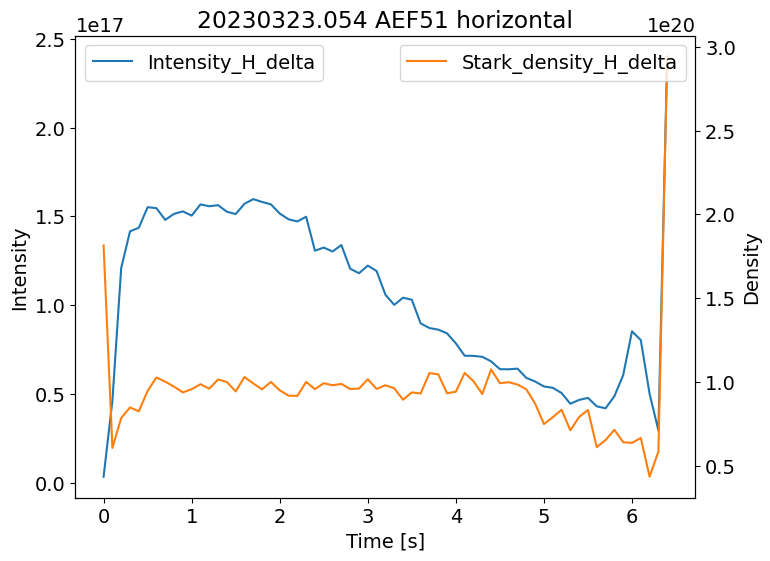

In [12]:
if True:
    importlib.reload(qss_juice)
    shotname = "20230323.054"
    strikeline = "horizontal"
    version = "_gauss"
    strongest_lines = ["410.173"]
    debug = True
    analysis_step = "100"
    debug_parameters = ["Intensity_H_delta", "Stark_density_H_delta"]
    #debug_parameters = None
    intensities,description = qss_juice.get_qss_max_intensities_brightest_channel(shotname=shotname,strikeline=strikeline,strongest_lines=strongest_lines,analysis_step=analysis_step,version=version,debug=debug,debug_parameters=debug_parameters)

### Single example

### Loading entire campaign into Juice!

In [13]:
if False:
    import archivedb
    from pathlib import Path
    shots = []
    #days = [ "2023-01-17","2023-01-18", "2023-01-19", "2023-01-25","2023-01-26", "2023-01-31", "2023-02-09","2023-02-22","2023-02-23","2023-03-07","2023-03-14","2023-03-15","2023-03-16","2023-03-23"]
    #days = ["2023-01-17","2023-01-18","2023-01-19","2023-01-25","2023-01-26", "2023-01-31","2023-02-09","2023-02-23","2023-03-15","2023-03-16","2023-03-23"] # only standard and dbm
    days = ["2022-11-29", "2022-11-30","2022-12-01","2022-12-06", "2022-12-07", "2022-12-13","2022-12-14","2022-12-15","2023-01-17","2023-01-18", "2023-01-19","2023-01-25","2023-01-26","2023-01-31", "2023-02-09","2023-02-14","2023-02-15","2023-02-16","2023-02-22","2023-02-23","2023-03-07","2023-03-14","2023-03-15","2023-03-16","2023-03-23"]
    for day in days:
        shotlist = archivedb.get_program_list_for_day(day,timeout=10)
        for shot in shotlist:
            shots.append(shot["id"])
    print(shots)
    # todo: go over all shots and rename the given file from 100s to 100ms, if it exists
    from pathlib import Path



    # Check if the old file exists before renaming
    if False: # my script to rename files
        for shot in shots:
            filename = ground_path + "qss_analysis/discharges/OP2.1/"+ shot[:8]+"/"+shot+"/"+"Fit_of_channels_max_intensity_intensities_410.173_AEF51_100s_gauss.json"
            old_file_path = Path(filename)
            new_file_path = Path(filename.replace("100s","100ms"))
            if old_file_path.exists():
                if new_file_path.exists():
                    print("File already exists at new path:", shot)
                else:
                    old_file_path.rename(new_file_path)
                    print("File renamed successfully!",shot)

In [14]:
if False:
    importlib.reload(qss_juice)
    path = "//share.ipp-hgw.mpg.de/documents/frhe/Documents/phd/qss_analysis/discharges/OP2.1/intensity_overview/Data/qss_stark_density_gauss_horizontal_juice_op21_step_0.2.csv"
    if True:
        juice_qss_stark_density_gauss_brightest_channel_horizontal = pd.read_csv(path,  index_col=0) 
    else:
        importlib.reload(qss_juice)
        juice_qss_stark_density_gauss_brightest_channel_horizontal = extractor.squeeze_shots(shots, time_step = 0.2,  modules = [qss_juice.squeeze_qss_max_intensities_brightest_line],
                                                                    module_settings={"strongest_lines":["410.173"], "strikeline":"horizontal","version":"_gauss","analysis_step":"100"},)
        juice_qss_stark_density_gauss_brightest_channel_horizontal = juice_qss_stark_density_gauss_brightest_channel_horizontal.drop(index=juice_qss_stark_density_gauss_brightest_channel_horizontal.index.difference(juice.index))
        juice_qss_stark_density_gauss_brightest_channel_horizontal.to_csv(path)
    path = "//share.ipp-hgw.mpg.de/documents/frhe/Documents/phd/qss_analysis/discharges/OP2.1/intensity_overview/Data/qss_stark_density_gauss_vertical_juice_op21_step_0.2.csv"
    
    if True:
        juice_qss_stark_density_gauss_brightest_channel_vertical = pd.read_csv(path,  index_col=0) 
    else:
        importlib.reload(qss_juice)
        juice_qss_stark_density_gauss_brightest_channel_vertical = extractor.squeeze_shots(shots, time_step = 0.2,  modules = [qss_juice.squeeze_qss_max_intensities_brightest_line],
                                                                    module_settings={"strongest_lines":["410.173"], "strikeline":"vertical","version":"_gauss","analysis_step":"100"})
        juice_qss_stark_density_gauss_brightest_channel_vertical = juice_qss_stark_density_gauss_brightest_channel_vertical.drop(index=juice_qss_stark_density_gauss_brightest_channel_vertical.index.difference(juice.index))
        juice_qss_stark_density_gauss_brightest_channel_vertical.to_csv(path)
    stark_density_horizontal = {'label':"Stark density brightest ch. horizontal target n$_e$ [$10^{19}$ m$^{-3}$]", 'data':juice_qss_stark_density_gauss_brightest_channel_horizontal["qss_brightest_channel_strikeline_Stark_density_H_delta"]/1e19, 'min':0, 'max': 20}
    stark_density_vertical = {'label':"Stark density brightest ch. vertical target n$_e$ [$10^{19}$ m$^{-3}$]", 'data':juice_qss_stark_density_gauss_brightest_channel_vertical["qss_brightest_channel_strikeline_Stark_density_H_delta"]/1e19, 'min':0, 'max': 20}
    balmer_delta_intensity_horizontal = {'label':"Max. Balmer Delta Intensity horizontal target [Photons/sr m$^2$]", 'data':juice_qss_stark_density_gauss_brightest_channel_horizontal["qss_brightest_channel_strikeline_Intensity_H_delta"], 'min':0, 'max': 5e17}
    balmer_delta_intensity_vertical = {'label':"Max. Balmer Delta Intensity vertical target [Photons/sr m$^2$]", 'data':juice_qss_stark_density_gauss_brightest_channel_vertical["qss_brightest_channel_strikeline_Intensity_H_delta"], 'min':0, 'max': 5e17}



### This functionality is for one datapoint per discharge
- Implemented to compare boronization of OP1.2b and OP2.1

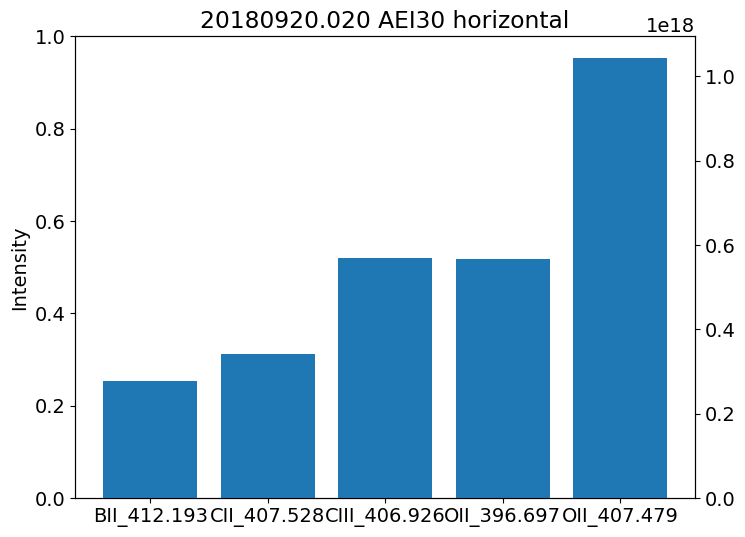

In [15]:
if True:
    importlib.reload(qss_juice)
    shotname = "20180920.020"
    strikeline = "horizontal"
    version = "boronization"
    debug = True
    port = "AEI30"
    debug_parameters = [ "Intensity_BII_412.193",
            "Intensity_CII_407.528",
            "Intensity_CIII_406.926",
            "Intensity_OII_396.697",
            "Intensity_OII_407.479"]
    #debug_parameters = None
    intensities,description = qss_juice.get_qss_average_intensities_full_discharge_fixed_channel(shotname=shotname,strikeline=strikeline,port=port,version=version,debug=debug,debug_parameters=debug_parameters)

In [16]:
if True:
    importlib.reload(qss_juice)
    path = "//share.ipp-hgw.mpg.de/documents/frhe/Documents/phd/qss_analysis/discharges/OP1.2b/Juice/average_intensity_full_discharge_horizontal_juice_op1.2b_step_0.2.csv"
    if False:
        juice_qss_average_intensities_full_discharge_fixed_channel_horizontal = pd.read_csv(path,  index_col=0) 
    else:
        import archivedb
        from pathlib import Path
        shots = []
        days = ["2018-09-20","2018-09-27","2018-10-02","2018-10-04","2018-10-10","2018-10-16","2018-10-18"]
        #days = ["2018-09-20"]
        for day in days:
            shotlist = archivedb.get_program_list_for_day(day,timeout=10)
            for shot in shotlist:
                shots.append(shot["id"])
        print(shots)
        importlib.reload(qss_juice)
        juice_qss_average_intensities_full_discharge_fixed_channel_horizontal = extractor.squeeze_shots(shots, time_step = 0.2,  modules = [qss_juice.squeeze_qss_average_intensities_full_discharge_fixed_channel],
                                                                    module_settings={"strikeline":"horizontal","version":"boronization","port":"AEI30"},)
        juice_qss_average_intensities_full_discharge_fixed_channel_horizontal = juice_qss_average_intensities_full_discharge_fixed_channel_horizontal.drop(index=juice_qss_average_intensities_full_discharge_fixed_channel_horizontal.index.difference(juice.index))
        juice_qss_average_intensities_full_discharge_fixed_channel_horizontal.to_csv(path)
   

['20180920.001', '20180920.002', '20180920.003', '20180920.004', '20180920.005', '20180920.006', '20180920.007', '20180920.008', '20180920.009', '20180920.010', '20180920.011', '20180920.012', '20180920.013', '20180920.014', '20180920.015', '20180920.016', '20180920.017', '20180920.018', '20180920.019', '20180920.020', '20180920.021', '20180920.022', '20180920.023', '20180920.024', '20180920.025', '20180920.026', '20180920.027', '20180920.028', '20180920.029', '20180920.030', '20180920.031', '20180920.032', '20180920.033', '20180920.034', '20180920.035', '20180920.036', '20180920.037', '20180920.038', '20180920.039', '20180920.040', '20180920.041', '20180920.042', '20180920.043', '20180920.044', '20180920.045', '20180920.046', '20180920.047', '20180920.048', '20180920.049', '20180920.050', '20180920.051', '20180920.052', '20180927.001', '20180927.002', '20180927.003', '20180927.004', '20180927.005', '20180927.006', '20180927.007', '20180927.008', '20180927.009', '20180927.010', '201809

In [17]:
fit_parameters = []
for element in list(juice_qss_average_intensities_full_discharge_fixed_channel_horizontal.columns):
    if "qss_average_intensity_full_discharge" in element:
        fit_parameters.append(element.split("qss_average_intensity_full_discharge_")[1])
for name in fit_parameters:
    globals()["qss_average_intensity_full_discharge_horizontal_{}".format(name.replace(".","_"))] = {"label":"QSS average full discharge {}".format(name),"data":juice_qss_average_intensities_full_discharge_fixed_channel_horizontal["qss_average_intensity_full_discharge_{}".format(name)],
                                                    "min":np.nanmin(juice_qss_average_intensities_full_discharge_fixed_channel_horizontal["qss_average_intensity_full_discharge_{}".format(name)]),
                                                    "max":np.nanmax(juice_qss_average_intensities_full_discharge_fixed_channel_horizontal["qss_average_intensity_full_discharge_{}".format(name)])}
oxygen_to_boron= {"label":"OII/BII","data":qss_average_intensity_full_discharge_horizontal_Intensity_OII_396_697["data"]/qss_average_intensity_full_discharge_horizontal_Intensity_BII_412_193["data"],"min":0,"max":10}   

### Displaying unique stuff - here we can't display parameters per strikeline

E: 54 55786
E: 12 55786


c:\Users\frhe\AppData\Local\anaconda3\envs\qss\lib\site-packages\ipykernel_launcher.py:139: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


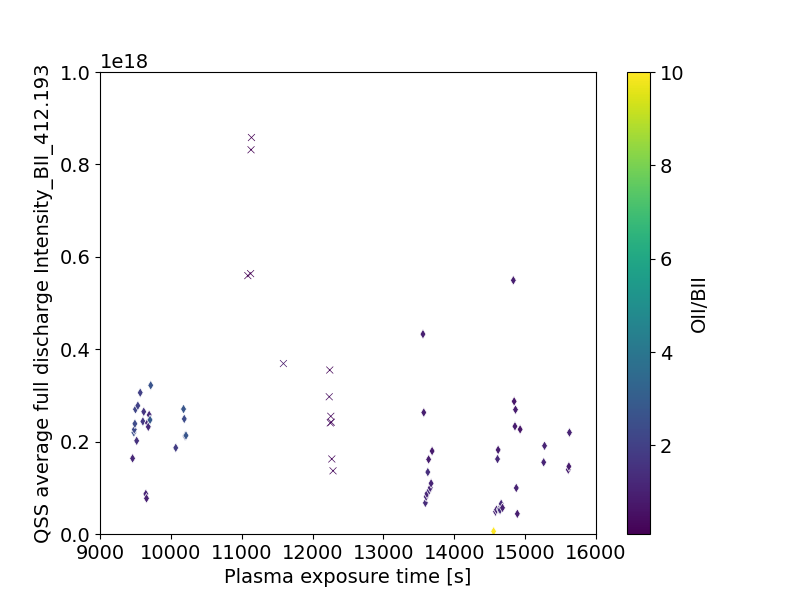

In [33]:
%matplotlib widget
if True:
    x = plasma_exposure_time
    #y = qss_positions_radiation_front_Intensity_NeII_371_046
    #y = qss_positions_radiation_front_Intensity_NII_399_500
    #y = qss_positions_radiation_front_Intensity_NIII_409_937
    #y = qss_positions_radiation_front_Intensity_CIII_406_926
    #y = qss_positions_radiation_front_Intensity_CIII_360_934
    z = oxygen_to_boron
    #y = power
    #y = balmer_delta_intensity_horizontal
    #z = qss_average_intensity_full_discharge_horizontal_Intensity_BII_412_193
    y = qss_average_intensity_full_discharge_horizontal_Intensity_OII_396_697
    y = qss_average_intensity_full_discharge_horizontal_Intensity_CII_407_528
    y = qss_average_intensity_full_discharge_horizontal_Intensity_BII_412_193

    markerSets = [
    #{ 'label':'High mirror.', 'filter': np.array([i.startswith("K") for i in list(juice["configuration"])]) , 'marker' : 'o', 'size':25, 'edgecolor':'w'},
    { 'label':'Standard', 'filter': np.array([i.startswith("E") for i in list(juice["configuration"])]) , 'marker' : 'd', 'size':25, 'edgecolor':'w'},
    { 'label':'Low Iota', 'filter': np.array([i.startswith("D") for i in list(juice["configuration"])]) , 'marker' : 'x', 'size':25, 'edgecolor':'w'},
    #{ 'label':list(juice['shot'][myShot])[0][3:], 'filter':myShot, 'marker' : 'd', 'size':100, 'edgecolor':'k'},
    #{"label":" ",'filter':juice["shot"]=="W7X"+"20230323.054", 'marker' : 'd', 'size':25, 'edgecolor':'w'}
            ]
    # filter data for cleaner plots
    # negative filter with ~ in front♠
    cfg = "EJM", "KJM", "KKM", "FTM", "DAM"
    cfg = "E"
    #cfg = "EJM"
    isCfg = np.array([i.startswith(cfg) for i in list(juice["configuration"])])    
    wo_nbi = ~np.array([i>0 for i in list(juice["shot_with_nbi"])])
    he_shots = np.array([i<0.8 for i in list(juice["h_to_he_corrected"])])
    slowchange_neL = np.abs(juice["dneL_dt_1e19_m2_s"])<3
    flt = (#(juice['ecrh_total_MW'] > .1) # ECRH data available and sensible
            #
            #(juice["neL_1e19_m2"] > 0.25) # density data available
            #& isAfter_firstBoron
            #& isCfg # defined magnetic configuration
            (pFraction["data"] < 10)
            #& ~(wo_nbi) #without NBI
            #& (power_nbi["data"]>.1)
            #& (juice["shot_with_nbi"]==1)
            #& (juice["nbi_total_MW"]>0.1)
            #& ((juice["shot_with_nbi"]==0) | (juice["t_in_shot"] < juice["t_nbi_start"]-0.1) | (juice["nbi_total_MW"] < 0.7)) # allow small blips
            #& ~he_shots # no He shots
    #        & ~wImpurity_Seeding #no impurity seeding
            #& ((juice["shot_with_tespel"] == 0) | (juice["t_in_shot"] < juice["t_tespel"]-0.1) | (juice["t_in_shot"] > juice["t_tespel"]+2.0)) #no tespel injection
            #& ((juice["shot_with_lbo"] == 0) | (juice["t_in_shot"] < juice["t_lbo_1"]-0.1) | (juice["t_in_shot"] > juice["t_lbo_1"]+2.0)) #no lbo
            #& (juice["shot_with_main_he_injection"] == 0) # presumably no He plasmas
            #& (juice["shot_with_main_ne_injection"] == 0) # no seeding through the main valves
            #& (juice["shot_with_main_n2_injection"] == 0)
            #& slowchange_neL # avoid fast drops in density
            #(juice["t_in_shot"] > 0.3) & (juice["t_shot_stop"]-juice["t_in_shot"] > 0.3) 
            #& (total_power["data"]>2.5)
            # skip start-up and shut-down
            #& ((juice["prad_hbc_MW"].isna()) | (juice["prad_hbc_MW"]/juice["ecrh_total_MW"] < 2)) &
            #((juice["prad_hbc_MW"].isna()) | (np.abs(juice["max_prad_hbc_MW"]-juice["min_prad_hbc_MW"])/juice["prad_hbc_MW"] < 1))
            #& (juice['prad_hbc_MW']>=0.0)
            # to avoid radiation collpase
    #        & (pFraction['data'] < 0.45)
            #& ((juice["shot_with_pellets"] == 0) | (juice["t_in_shot"] < juice["t_pellet_start"]-0.1) | (juice["t_in_shot"] > juice["t_pellet_stop"]+2.0)) # no pellet injections
            #& (z["data"]>np.nanmax(z["data"]))
            #& (control_coil_operation["data"] == 1)
            #& wImpurity_Seeding_Ne
            #& wImpurity_Seeding_N2
            #& wImpurity_Seeding_Ar
            #& ~(qss_max_Intensity_HeI_396_473["data"]>1e15) # this takes out he main gas discharges
            #& ((qss_max_intensities_horizontal_Intensity_NeII_371_755["data"]>.1e17) )
            #& ((qss_max_intensities_horizontal_Intensity_NII_399_500["data"]>.1e17))
            #& (qss_max_intensities_horizontal_Intensity_NIII_409_937["data"]>.1e16)
            #& (qss_max_Intensity_NII_399_500["data"] > 1e15)
            #& (qss_Intensity_ArII_401["data"]<1e15)
            #& ~wImpurity_Seeding_He
            )
    #z["max"] = 1.3#np.nanmax(z["data"][flt])
    #x["min"] = 0.5e20
    #x["max"] = 2e20#np.nanmax(x["data"][flt])
    if True:
            x["max"] = np.nanmax(x["data"][flt])
            y["max"] = np.nanmax(y["data"][flt])
            z["max"] = np.nanmax(z["data"][flt])
            y["min"] = np.nanmin(y["data"][flt])
            z["min"] = np.nanmin(z["data"][flt])
            x["min"] = np.nanmin(x["data"][flt])
    x["min"] = 9000
    x["max"] = 16000
    z["min"] = 0.1
    z["max"] = 10
    y["min"] = 0.1
    y["max"] = 10e17
    #y["min"] = 1e14

    #%matplotlib widget
    importlib.reload(utils)
    fontsize = 14
    plt.rcParams.update({'font.size': fontsize})
    #%matplotlib widget
    debugPlot = True
    #Function to allow you to click on individual points in the juice plot and see shot and time it belongs to
    fltSel = flt & np.isfinite(y['data']) #& markerSets[0]['filter']
    def onclick(event):
        global lastSelPlot
        if event.inaxes is not ax1 :
            return
        if lastSelPlot is not None :
            for p in lastSelPlot :
                p.remove()    
                

        #tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
        flt = fltSel
        j = np.nanargmin((x['data'][flt] - event.xdata)**2 + (y['data'][flt] - event.ydata)**2)
        xx = np.array(x['data'][flt])[j]
        yy = np.array(y['data'][flt])[j]
        tSel = np.array(juice['t_in_shot'][flt])[j];
    #    dt = np.array(juice['time_step'][flt])[j];

        progID = np.array(juice['shot'][flt])[j][3:]
        tx = "%s: t=%.2f x=%f y=%f" % (progID, tSel, xx, yy)
        lastSelPlot = ax1.plot(xx, yy, "o", color="black", lw=2, ms=20, fillstyle='none')
        ax.set_title(tx)
        

    #fig = plt.figure(figsize=(12,8))
    fig = plt.figure(figsize=(8,6))
    ax1=plt.subplot(1,1,1)
    #ax1.set_title("Standard magnetic field config")
    for iS, markerSet in enumerate(markerSets) :
        #print(flt)
        #print(markerSet['filter'])
        #print((np.isfinite(x['data']) & np.isfinite(y['data']) & np.isfinite(z['data'])))
        i = (flt & markerSet['filter'] & ((np.isfinite(x['data']) & np.isfinite(y['data']) & np.isfinite(z['data']))))
        xd=x['data'][i]; yd=y['data'][i]; zd=z['data'][i]
        print("%s: %i %i" % (cfg, i.sum(), isCfg.sum()))
        #print(xd)
        #print(yd)
        #print(zd)
        plt.scatter(xd, yd, c=zd, vmin=z['min'], vmax=z['max'], 
                s=markerSet['size'], edgecolors = markerSet['edgecolor'],
                marker=markerSet['marker'], linewidth = 0.5, label=markerSet['label'], cmap="viridis"); 
                    
    cb=plt.colorbar()
    ax=plt.gca()
    ax.set_xlim(x['min'], x['max'])
    ax.set_ylim(y['min'], y['max'])
    ax.set_xlabel(x['label'])
    ax.set_ylabel(y['label'])
    yscale = "linear"
    #yscale = "log"
    ax.set_yscale(yscale)
    cb.set_label(z['label'])
    #utils.multicolor_ylabel(ax,["Neon line ratio","371.3","/","371.7"],list_of_colors=["darkblue","black","darkred","black"],axis="y")
    #utils.multicolor_ylabel(ax,["Neon line ratio","357.1","/","371.3"],list_of_colors=["black","darkmagenta","black","darkred"],axis="x")
    if debugPlot:
        lastSelPlot = None
        plt.show()
        cid = fig.canvas.mpl_connect('button_press_event', onclick)

    for boronization in plasma_exposure_times_of_boronizations:
        plt.axvline(boronization, color='r', linestyle='--')
    plt.grid(True)
    if False:
        handles, labels = plt.gca().get_legend_handles_labels()
        # Exclude the last handle and label
        handles = handles[:-1]
        labels = labels[:-1]

        # Create the legend with the specified handles and labels
        plt.legend(handles, labels)
    plt.title("OP1.2b, AEI30, Divertor spectroscopy")
    if True:
        plt.legend()
    plt.tight_layout()
    #plt.title("Divertor NeII max intensities, configs")
    if not debugPlot:
        plt.show()

In [19]:
asdf

NameError: name 'asdf' is not defined

### Displaying stuff that needs two axis for both the strikelines:

('EJM', 'KJM', 'KKM', 'FTM', 'DAM'): 945 109178


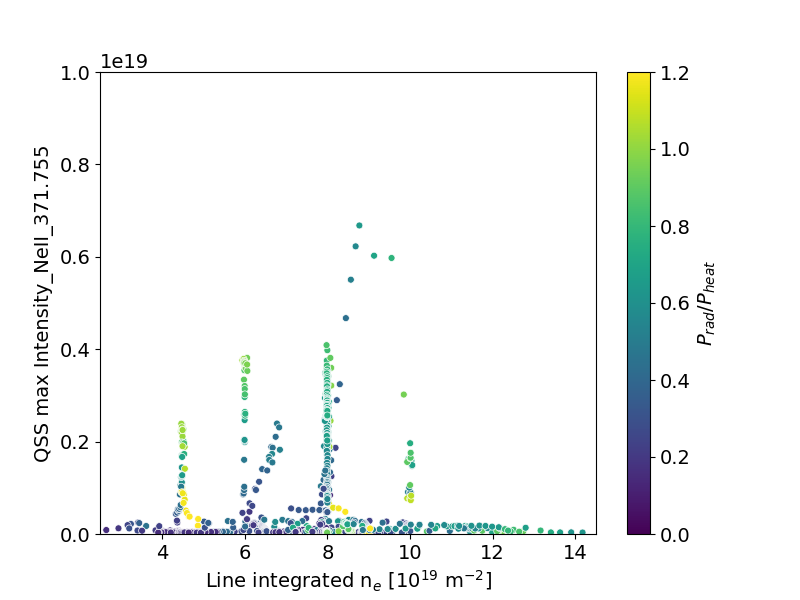

In [ ]:
%matplotlib widget
#z = pFraction
#y = pRad
#x = pFraction
#x = edgeDensity_norm
#y = qss_Intensity_NII_399
#z = nII_ratio
z = pFraction
#z = balmer_delta_intensity_horizontal
#z = total_power
#z = power
#z = pRad
#y = qss_max_Intensity_Balmer_H_delta
#x = qss_max_Intensity_NII_399_500
#z = qss_max_Intensity_CIII_406_926
#y = qss_max_Intensity_NII_399_500
#z = qss_Intensity_Balmer_H_delta
#z = total_power
#y = qss_max_Intensity_NII_399_500
#y = qss_Intensity_Balmer_H_delta
#z = stark_density
#y = ratio_balmer
#z = Zeff
#z = qss_Intensity_NIII_409
#z= qss_Intensity_Balmer_H_delta
#z = qss_Intensity_CIII_406
#y = qss_Intensity_ArII_401
#z = qss_Intensity_NII_399
#y = qss_max_intensities_horizontal_Intensity_NeII3s2D_3p2F_357_111
#y = qss_max_intensities_vertical_Intensity_NeII3s2P_3p2D_371_315
#y2 = qss_max_intensities_horizontal_Intensity_NeII3s2P_3p2D_371_315
#y2 = qss_max_intensities_horizontal_Intensity_NeII3s4P_3p4P_371_046
#y = qss_max_intensities_vertical_Intensity_NeII3s4P_3p4P_371_046
#y = qss_max_intensities_vertical_Intensity_NII_399_500
#y2 = qss_max_intensities_horizontal_Intensity_NII_399_500
#y = qss_max_intensities_vertical_Intensity_NeII_371_755
#y2 = qss_max_intensities_horizontal_Intensity_NeII_371_755
#y = qss_max_intensities_vertical_Intensity_CIII_406_926
#y2 = qss_max_intensities_horizontal_Intensity_CIII_406_926

#y = qss_max_intensities_vertical_Intensity_Balmer_H_delta
#y2 = qss_max_intensities_horizontal_Intensity_Balmer_H_delta
#y = line_ratio_vertical_nII
#y2 = line_ratio_horizontal_nII
#y = stark_density_horizontal
#y2 = stark_density_vertical
x = line_ratio_horizontal_neII1
x2 = line_ratio_vertical_neII1
y = line_ratio_horizontal_neII2
y2 = line_ratio_vertical_neII2
x = lineDensity
x2 = lineDensity
y = qss_max_intensities_horizontal_Intensity_NeII_371_755
y2 = qss_max_intensities_vertical_Intensity_NeII_371_755
#x = ne_ratio1_brightest_channel_horizontal
#x2 = ne_ratio1_brightest_channel_vertical
#y = ne_ratio2_brightest_channel_horizontal
#y2 = ne_ratio2_brightest_channel_vertical
#y = ne3717_brightest_channel_horizontal
#y2 = ne3717_brightest_channel_vertical
#y = test
#y = qss_max_Intensity_CIII_406_926
#x = qss_average_Intensity_CIII_406_926
#y = qss_average_Intensity_CIII_360_934
#y = line_ratio_oII
#y = line_ratio_cIII
#y = qss_average_Intensity_BII_412_193
#y = qss_average_Intensity_OII_396_697
#y = qss_average_Intensity_Balmer_H_delta
#y = qss_max_Intensity_Balmer_H_delta
#y = qss_average_Intensity_ArII_401_386
#x = line_ratio_neII1
#y = line_ratio_n
#x = control_coil_current

import copy
tmp = copy.copy(stark_density_horizontal)
tmp['data'] = stark_density_horizontal['data']/(np.abs(control_coil_current['data'])+1.5)**-0.35
tmp['label'] = 'TMP'

#y = tmp
#y = stark_density_horizontal
#y = stark_density_horizontal
#y2 = stark_density_vertical
x = lineDensity
x2 = lineDensity
#x = control_coil_current
z = pFraction
#z = balmer_delta_intensity_horizontal
#y = lineDensity
#z = time
#shot = "20230119.041"
shot = "20230323.054"
#shot = "20230209.019"
myShot = np.array([i.find("W7X"+shot) >= 0 for i in juice['shot']])

markerSets = [
     { 'label':'all', 'filter':pFraction['data'] > 0.000001, 'marker' : 'o', 'size':25, 'edgecolor':'w'},
     #{ 'label':'f$_{rad}$ > 0.45', 'filter':pFraction['data'] < 0.45, 'marker' : 'o', 'size':25, 'edgecolor':'w'},
     #{ 'label':'f$_{rad} \geq$ 0.45', 'filter':pFraction['data'] >= 0.45, 'marker' : '^', 'size':50, 'edgecolor':'w'},
     #{ 'label':list(juice['shot'][myShot])[0][3:], 'filter':myShot, 'marker' : 'd', 'size':100, 'edgecolor':'k'},
     #{ 'label':"Impurity Seeding", 'filter':wImpurity_Seeding, 'marker' : 'd', 'size':100, 'edgecolor':'k'},
            ]
if True:
        markerSets2 = [ # vertical target
        { 'label':'High mirror vert.', 'filter': np.array([i.startswith("K") for i in list(juice["configuration"])]) , 'marker' : 'o', 'size':25, 'edgecolor':'w'},
        #{ 'label':'Standard vert.', 'filter': np.array([i.startswith("E") for i in list(juice["configuration"])]) , 'marker' : 'd', 'size':25, 'edgecolor':'w'},
        #{ 'label':'D', 'filter': np.array([i.startswith("D") for i in list(juice["configuration"])]) , 'marker' : 'x', 'size':25, 'edgecolor':'w'},
        #{ 'label':list(juice['shot'][myShot])[0][3:], 'filter':myShot, 'marker' : 'd', 'size':100, 'edgecolor':'k'},
        #{"label":" ",'filter':juice["shot"]=="W7X"+"20230323.054", 'marker' : 'd', 'size':25, 'edgecolor':'w'}
                ]
        markerSets = [ # horizontal target
        #{ 'label':'K', 'filter': np.array([i.startswith("K") for i in list(juice["configuration"])]) , 'marker' : 'o', 'size':25, 'edgecolor':'w'},
        #{ 'label':'Standard hor.', 'filter': np.array([i.startswith("E") for i in list(juice["configuration"])]) , 'marker' : 's', 'size':25, 'edgecolor':'w'},
        #{ 'label':'Low iota hor.', 'filter': np.array([i.startswith("D") for i in list(juice["configuration"])]) , 'marker' : '^', 'size':25, 'edgecolor':'w'},
        #{ 'label':list(juice['shot'][myShot])[0][3:], 'filter':myShot, 'marker' : 'd', 'size':100, 'edgecolor':'k'},
        #{"label":" ",'filter':juice["shot"]=="W7X"+"20230323.054", 'marker' : 'd', 'size':25, 'edgecolor':'w'}
                ]
# filter data for cleaner plots
# negative filter with ~ in front♠
cfg = "EJM", "KJM", "KKM", "FTM", "DAM"
#cfg = "E"
#cfg = "EJM"
isCfg = np.array([i.startswith(cfg) for i in list(juice["configuration"])])    
is_forward_field = np.array(["+" in i for i in list(juice["configuration"])]) 
wo_nbi = ~np.array([i>0 for i in list(juice["shot_with_nbi"])])
he_shots = np.array([i<0.8 for i in list(juice["h_to_he_corrected"])])
#he_shots = np.array([i==True for i in list(juice["shot_with_main_he_injection"])])
#h2_shots = np.array([i==True for i in list(juice["shot_with_main_h2_injection"])])

slowchange_neL = np.abs(juice["dneL_dt_1e19_m2_s"])<3
wImpurity_Seeding_He = np.array([i>0 for i in list(juice["shot_with_divertor_He_injection"])])
wImpurity_Seeding_Ne = np.array([i>0 for i in list(juice["shot_with_divertor_Ne_injection"])])
wImpurity_Seeding_Ar = np.array([i>0 for i in list(juice["shot_with_divertor_Ar_injection"])])
wImpurity_Seeding_N2 = np.array([i>0 for i in list(juice["shot_with_divertor_N2_injection"])])
wImpurity_Seeding = wImpurity_Seeding_Ne | wImpurity_Seeding_Ar | wImpurity_Seeding_N2
flt = (#(juice['ecrh_total_MW'] > .1) # ECRH data available and sensible
        #
        (juice["neL_1e19_m2"] > 0.25) # density data available
        #& (lineDensity["data"]>5.5)
        #& (lineDensity["data"]<6.5)
        #& isAfter_firstBoron
        #& isCfg # defined magnetic configuration
        #& ~is_forward_field
        #& (pFraction["data"] < 0.8)
        #& (pFraction["data"] > 0.3)
        #& ~(wo_nbi) #without NBI
        #& (power_nbi["data"]>.1)
        #& (juice["shot_with_nbi"]==1)
        #& (juice["nbi_total_MW"]>0.1)
        #& ((juice["shot_with_nbi"]==0) | (juice["t_in_shot"] < juice["t_nbi_start"]-0.1) | (juice["nbi_total_MW"] < 0.7)) # allow small blips
        #& ~he_shots # no He shots
        #& h2_shots
# & ~wImpurity_Seeding #no impurity seeding
        #& ((juice["shot_with_tespel"] == 0) | (juice["t_in_shot"] < juice["t_tespel"]-0.1) | (juice["t_in_shot"] > juice["t_tespel"]+2.0)) #no tespel injection
        #& ((juice["shot_with_lbo"] == 0) | (juice["t_in_shot"] < juice["t_lbo_1"]-0.1) | (juice["t_in_shot"] > juice["t_lbo_1"]+2.0)) #no lbo
        #& (juice["shot_with_main_he_injection"] == 0) # presumably no He plasmas
        #& (juice["shot_with_main_ne_injection"] == 0) # no seeding through the main valves
        #& (juice["shot_with_main_n2_injection"] == 0)
        #& slowchange_neL # avoid fast drops in density
        #(juice["t_in_shot"] > 0.3) & (juice["t_shot_stop"]-juice["t_in_shot"] > 0.3) 
        #& (total_power["data"]>2.5)
        # skip start-up and shut-down
        #& ((juice["prad_hbc_MW"].isna()) | (juice["prad_hbc_MW"]/juice["ecrh_total_MW"] < 2)) &
        #((juice["prad_hbc_MW"].isna()) | (np.abs(juice["max_prad_hbc_MW"]-juice["min_prad_hbc_MW"])/juice["prad_hbc_MW"] < 1))
        #& (juice['prad_hbc_MW']>=0.0)
        # to avoid radiation collpase
#        & (pFraction['data'] < 0.45)
        #& ((juice["shot_with_pellets"] == 0) | (juice["t_in_shot"] < juice["t_pellet_start"]-0.1) | (juice["t_in_shot"] > juice["t_pellet_stop"]+2.0)) # no pellet injections
        #& (z["data"]>np.nanmax(z["data"]))
        #& (control_coil_operation["data"] == 1)
        #& wImpurity_Seeding_Ne
        #& wImpurity_Seeding_N2
        #& wImpurity_Seeding_Ar
        #& ((balmer_delta_intensity_horizontal["data"] > 1e16) | (balmer_delta_intensity_vertical["data"] > 1e16))
        #& ~(qss_max_Intensity_HeI_396_473["data"]>1e15) # this takes out he main gas discharges
        & ((qss_max_intensities_horizontal_Intensity_NeII_371_755["data"]>.3e17) | (qss_max_intensities_vertical_Intensity_NeII_371_755["data"]>.3e17))
        #& ((qss_max_intensities_horizontal_Intensity_NII_399_500["data"]>.1e17) | (qss_max_intensities_vertical_Intensity_NII_399_500["data"]>.1e17))
        #& (qss_max_Intensity_NII_399_500["data"] > 1e15)
        #& (qss_Intensity_ArII_401["data"]<1e15)
        #& ~wImpurity_Seeding_He
        )
#z["max"] = 1.3#np.nanmax(z["data"][flt])
#x["min"] = 0.5e20
#x["max"] = 2e20#np.nanmax(x["data"][flt])
if True:
        x["max"] = np.nanmax(x["data"][flt])
        y["max"] = np.nanmax(y["data"][flt])
        z["max"] = np.nanmax(z["data"][flt])
        y["min"] = np.nanmin(y["data"][flt])
        z["min"] = np.nanmin(z["data"][flt])
        x["min"] = np.nanmin(x["data"][flt])
x["min"] = 2.5
x["max"] = 14.5
y["min"] = 0
y["max"] = 1e19
z["min"] = 0
z["max"] = 1.2
#y["min"] = 1e14

#%matplotlib widget
importlib.reload(utils)
fontsize = 14
plt.rcParams.update({'font.size': fontsize})
#%matplotlib widget
debugPlot = True
#Function to allow you to click on individual points in the juice plot and see shot and time it belongs to
fltSel = flt & np.isfinite(y2['data']) #& markerSets[0]['filter']
def onclick(event):
    global lastSelPlot
    if event.inaxes is not ax1 :
        return
    if lastSelPlot is not None :
        for p in lastSelPlot :
            p.remove()    
            

    #tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
    flt = fltSel
    j = np.nanargmin((x2['data'][flt] - event.xdata)**2 + (y2['data'][flt] - event.ydata)**2)
    xx = np.array(x2['data'][flt])[j]
    yy = np.array(y2['data'][flt])[j]
    tSel = np.array(juice['t_in_shot'][flt])[j];
#    dt = np.array(juice['time_step'][flt])[j];

    progID = np.array(juice['shot'][flt])[j][3:]
    tx = "%s: t=%.2f x=%f y=%f" % (progID, tSel, xx, yy)
    lastSelPlot = ax1.plot(xx, yy, "o", color="black", lw=2, ms=20, fillstyle='none')
    ax.set_title(tx)
    

#fig = plt.figure(figsize=(12,8))
fig = plt.figure(figsize=(8,6))
ax1=plt.subplot(1,1,1)
#ax1.set_title("Standard magnetic field config")
for iS, markerSet in enumerate(markerSets) :
    #print(flt)
    #print(markerSet['filter'])
    #print((np.isfinite(x['data']) & np.isfinite(y['data']) & np.isfinite(z['data'])))
    i = (flt & markerSet['filter'] & ((np.isfinite(x['data']) & np.isfinite(y['data']) & np.isfinite(z['data']))))
    xd=x['data'][i]; yd=y['data'][i]; zd=z['data'][i]
    print("%s: %i %i" % (cfg, i.sum(), isCfg.sum()))
    #print(xd)
    #print(yd)
    #print(zd)
    plt.scatter(xd, yd, c=zd, vmin=z['min'], vmax=z['max'], 
             s=markerSet['size'], edgecolors = markerSet['edgecolor'],
            marker=markerSet['marker'], linewidth = 0.5, label=markerSet['label'], cmap="viridis"); 
if True:
    for iS, markerSet in enumerate(markerSets2) :
        #print(flt)
        #print(markerSet['filter'])
        #print((np.isfinite(x['data']) & np.isfinite(y['data']) & np.isfinite(z['data'])))
        i = (flt & markerSet['filter'] & ((np.isfinite(x2['data']) & np.isfinite(y2['data']) & np.isfinite(z['data']))))
        xd=x2['data'][i]; yd=y2['data'][i]; zd=z['data'][i]
        print("%s: %i %i" % (cfg, i.sum(), isCfg.sum()))
        #print(xd)
        #print(yd)
        #print(zd)
        plt.scatter(xd, yd, c=zd, vmin=z['min'], vmax=z['max'], 
                s=markerSet['size'], edgecolors = markerSet['edgecolor'],
                marker=markerSet['marker'], linewidth = 0.5, label=markerSet['label'], cmap="viridis"); 
                
cb=plt.colorbar()
ax=plt.gca()
ax.set_xlim(x['min'], x['max'])
ax.set_ylim(y['min'], y['max'])
yscale = "linear"
#yscale = "log"
ax.set_yscale(yscale)
cb.set_label(z['label'])
if False:
    utils.multicolor_ylabel(ax,["Neon line ratio","371.3","/","371.7"],list_of_colors=["darkblue","black","darkred","black"],axis="y")
    utils.multicolor_ylabel(ax,["Neon line ratio","357.1","/","371.3"],list_of_colors=["black","darkmagenta","black","darkred"],axis="x")
else: 
    ax.set_xlabel(x['label'])
    ax.set_ylabel(y['label'])
if debugPlot:
    lastSelPlot = None
    plt.show()
    cid = fig.canvas.mpl_connect('button_press_event', onclick)


plt.grid(True)
if False:
    handles, labels = plt.gca().get_legend_handles_labels()
    # Exclude the last handle and label
    handles = handles[:-1]
    labels = labels[:-1]

    # Create the legend with the specified handles and labels
    plt.legend(handles, labels)
if True:
    plt.legend() 
#plt.title("Stark Density")
plt.ylabel("Stark density [10$^{19}$ m$^{-3}$]")
plt.tight_layout()
    
if not debugPlot:
    plt.show()

In [ ]:
asdf

NameError: name 'asdf' is not defined

### Can it ever lead to a problem, if the juice files have different length? 

In [ ]:
##### assign to an axis
#z = pFraction
#y = pRad
#x = pFraction
#x = edgeDensity_norm
#y = qss_Intensity_NII_399
#z = nII_ratio
z = lineDensity
z2 = lineDensity
z = qss_max_intensities_vertical_Stark_density_H_delta
z2 = qss_max_intensities_horizontal_Stark_density_H_delta
#z = total_power
#z = power
#z = pRad
#y = qss_max_Intensity_Balmer_H_delta
#x = qss_max_Intensity_NII_399_500
#z = qss_max_Intensity_CIII_406_926
#y = qss_max_Intensity_NII_399_500
#z = qss_Intensity_Balmer_H_delta
#z = total_power
#y = qss_max_Intensity_NII_399_500
#y = qss_Intensity_Balmer_H_delta
#z = stark_density
#y = ratio_balmer
#z = Zeff
#z = qss_Intensity_NIII_409
#z= qss_Intensity_Balmer_H_delta
#z = qss_Intensity_CIII_406
#y = qss_Intensity_ArII_401
#z = qss_Intensity_NII_399
x = line_ratio_vertical_neII1
y = line_ratio_vertical_neII2
x2 = line_ratio_horizontal_neII1
y2 = line_ratio_horizontal_neII2
#y = test
#y = qss_max_Intensity_CIII_406_926
#x = qss_average_Intensity_CIII_406_926
#y = qss_average_Intensity_CIII_360_934
#y = line_ratio_oII
#y = line_ratio_cIII
#y = qss_average_Intensity_BII_412_193
#y = qss_average_Intensity_OII_396_697
#y = qss_average_Intensity_Balmer_H_delta
#y = qss_max_Intensity_Balmer_H_delta
#y = qss_average_Intensity_ArII_401_386
#y = line_ratio_neII2
#x = line_ratio_neII1
#y = line_ratio_n
#z = control_coil_current
#z2 = control_coil_current
#y = stark_density
#z = lineDensity
#z2 = lineDensity
#z = pFraction
#z2 = pFraction
#y = lineDensity
#z = time
#shot = "20230119.041"
shot = "20230323.054"
#shot = "20230209.019"
myShot = np.array([i.find("W7X"+shot) >= 0 for i in juice['shot']])

NameError: name 'qss_max_intensities_vertical_Stark_density_H_delta' is not defined

In [ ]:
markerSets = [
     { 'label':'all', 'filter':pFraction['data'] > 0.000001, 'marker' : 'o', 'size':25, 'edgecolor':'w'},
     #{ 'label':'f$_{rad}$ > 0.45', 'filter':pFraction['data'] < 0.45, 'marker' : 'o', 'size':25, 'edgecolor':'w'},
     #{ 'label':'f$_{rad} \geq$ 0.45', 'filter':pFraction['data'] >= 0.45, 'marker' : '^', 'size':50, 'edgecolor':'w'},
     #{ 'label':list(juice['shot'][myShot])[0][3:], 'filter':myShot, 'marker' : 'd', 'size':100, 'edgecolor':'k'},
     #{ 'label':"Impurity Seeding", 'filter':wImpurity_Seeding, 'marker' : 'd', 'size':100, 'edgecolor':'k'},
            ]
if True:
        markerSets = [
        { 'label':'High mirror vert.', 'filter': np.array([i.startswith("K") for i in list(juice["configuration"])]) , 'marker' : 'o', 'size':25, 'edgecolor':'w'},
        #{ 'label':'Standard vert.', 'filter': np.array([i.startswith("E") for i in list(juice["configuration"])]) , 'marker' : 'd', 'size':25, 'edgecolor':'w'},
        #{ 'label':'D', 'filter': np.array([i.startswith("D") for i in list(juice["configuration"])]) , 'marker' : 'x', 'size':25, 'edgecolor':'w'},
        #{ 'label':list(juice['shot'][myShot])[0][3:], 'filter':myShot, 'marker' : 'd', 'size':100, 'edgecolor':'k'},
        #{"label":" ",'filter':juice["shot"]=="W7X"+"20230323.054", 'marker' : 'd', 'size':25, 'edgecolor':'w'}
                ]
        markerSets2 = [
        #{ 'label':'K', 'filter': np.array([i.startswith("K") for i in list(juice["configuration"])]) , 'marker' : 'o', 'size':25, 'edgecolor':'w'},
        #{ 'label':'Standard hor.', 'filter': np.array([i.startswith("E") for i in list(juice["configuration"])]) , 'marker' : 's', 'size':25, 'edgecolor':'w'},
        #{ 'label':'Low iota hor.', 'filter': np.array([i.startswith("D") for i in list(juice["configuration"])]) , 'marker' : '^', 'size':25, 'edgecolor':'w'},
        #{ 'label':list(juice['shot'][myShot])[0][3:], 'filter':myShot, 'marker' : 'd', 'size':100, 'edgecolor':'k'},
        #{"label":" ",'filter':juice["shot"]=="W7X"+"20230323.054", 'marker' : 'd', 'size':25, 'edgecolor':'w'}
                ]
# filter data for cleaner plots
# negative filter with ~ in front♠
cfg = "EJM", "KJM", "KKM", "FTM", "DAM"
cfg = "E"
#cfg = "EJM"
isCfg = np.array([i.startswith(cfg) for i in list(juice["configuration"])])    
wo_nbi = ~np.array([i>0 for i in list(juice["shot_with_nbi"])])
he_shots = np.array([i<0.8 for i in list(juice["h_to_he_corrected"])])
h2_shots = 
slowchange_neL = np.abs(juice["dneL_dt_1e19_m2_s"])<3
wImpurity_Seeding_He = np.array([i>0 for i in list(juice["shot_with_divertor_He_injection"])])
wImpurity_Seeding_Ne = np.array([i>0 for i in list(juice["shot_with_divertor_Ne_injection"])])
wImpurity_Seeding_Ar = np.array([i>0 for i in list(juice["shot_with_divertor_Ar_injection"])])
wImpurity_Seeding_N2 = np.array([i>0 for i in list(juice["shot_with_divertor_N2_injection"])])
wImpurity_Seeding = wImpurity_Seeding_Ne | wImpurity_Seeding_Ar | wImpurity_Seeding_N2
flt = (#(juice['ecrh_total_MW'] > .1) # ECRH data available and sensible
        #
        (juice["neL_1e19_m2"] > 0.25) # density data available
        #& isAfter_firstBoron
        #& isCfg # defined magnetic configuration
        &(pFraction["data"] < 0.9)
        #& (pFraction["data"] > 0.1)
        #& ~(wo_nbi) #without NBI
        #& (power_nbi["data"]>.1)
        #& (juice["shot_with_nbi"]==1)
        #& (juice["nbi_total_MW"]>0.1)
        #& ((juice["shot_with_nbi"]==0) | (juice["t_in_shot"] < juice["t_nbi_start"]-0.1) | (juice["nbi_total_MW"] < 0.7)) # allow small blips
        #& ~he_shots # no He shots
#        & ~wImpurity_Seeding #no impurity seeding
        #& ((juice["shot_with_tespel"] == 0) | (juice["t_in_shot"] < juice["t_tespel"]-0.1) | (juice["t_in_shot"] > juice["t_tespel"]+2.0)) #no tespel injection
        #& ((juice["shot_with_lbo"] == 0) | (juice["t_in_shot"] < juice["t_lbo_1"]-0.1) | (juice["t_in_shot"] > juice["t_lbo_1"]+2.0)) #no lbo
        #& (juice["shot_with_main_he_injection"] == 0) # presumably no He plasmas
        #& (juice["shot_with_main_ne_injection"] == 0) # no seeding through the main valves
        #& (juice["shot_with_main_n2_injection"] == 0)
        #& slowchange_neL # avoid fast drops in density
        #(juice["t_in_shot"] > 0.3) & (juice["t_shot_stop"]-juice["t_in_shot"] > 0.3) 
        #& (total_power["data"]>5)
        # skip start-up and shut-down
        #& ((juice["prad_hbc_MW"].isna()) | (juice["prad_hbc_MW"]/juice["ecrh_total_MW"] < 2)) &
        #((juice["prad_hbc_MW"].isna()) | (np.abs(juice["max_prad_hbc_MW"]-juice["min_prad_hbc_MW"])/juice["prad_hbc_MW"] < 1))
        #& (juice['prad_hbc_MW']>=0.0)
        # to avoid radiation collpase
#        & (pFraction['data'] < 0.45)
        #& ((juice["shot_with_pellets"] == 0) | (juice["t_in_shot"] < juice["t_pellet_start"]-0.1) | (juice["t_in_shot"] > juice["t_pellet_stop"]+2.0)) # no pellet injections
        #& (z["data"]>np.nanmax(z["data"]))
        #& (control_coil_operation["data"] == 1)
        #& wImpurity_Seeding_Ne
        #& wImpurity_Seeding_N2
        #& wImpurity_Seeding_Ar
        #& ~(qss_max_Intensity_HeI_396_473["data"]>1e15) # this takes out he main gas discharges
        #& (qss_max_Intensity_NeII_371_755["data"]<.1e17)
        #& (qss_max_Intensity_NII_399_500["data"] > 1e15)
        #& (qss_Intensity_ArII_401["data"]<1e15)
        #& ~wImpurity_Seeding_He
        )
#z["max"] = 1.3#np.nanmax(z["data"][flt])
#x["min"] = 0.5e20
#x["max"] = 2e20#np.nanmax(x["data"][flt])
if False:
        x["max"] = np.nanmax(x["data"][flt])
        y["max"] = np.nanmax(y["data"][flt])
        z["max"] = np.nanmax(z["data"][flt])
        y["min"] = np.nanmin(y["data"][flt])
        z["min"] = np.nanmin(z["data"][flt])
        x["min"] = np.nanmin(x["data"][flt])
y["min"] = 0.23
y["max"] = 0.375
#y["max"] = 0.65
x["min"] = 0.225
x["min"] = 0.275
x["max"] = 0.5
x["max"] = 0.45
z["min"] = 0.5e20
z["max"] = 1.6e20
#z["min"] = 4
#z["max"] = 10
#y["min"] = 1e14

('EJM', 'KJM', 'KKM', 'FTM', 'DAM'): 185 109178
('EJM', 'KJM', 'KKM', 'FTM', 'DAM'): 390 109178
('EJM', 'KJM', 'KKM', 'FTM', 'DAM'): 185 109178


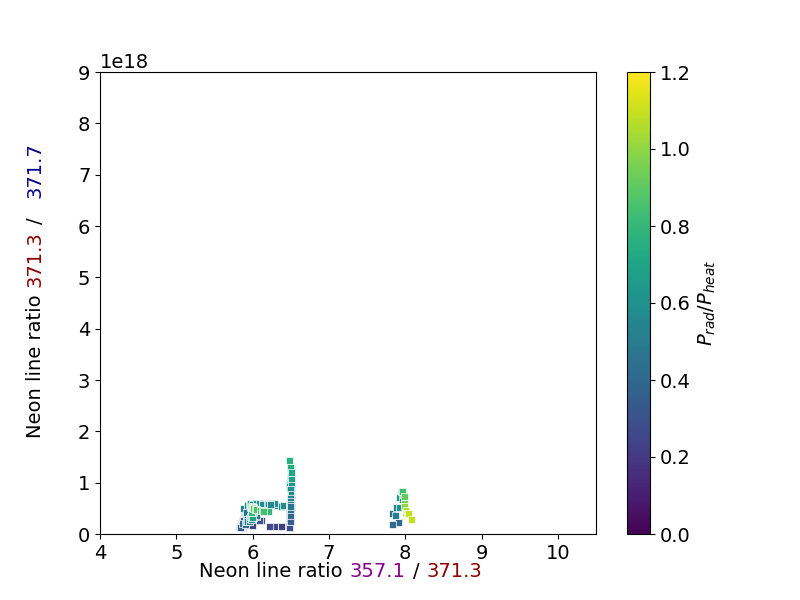

In [ ]:
#%matplotlib widget
importlib.reload(utils)
fontsize = 14
plt.rcParams.update({'font.size': fontsize})
#%matplotlib widget
debugPlot = True
#Function to allow you to click on individual points in the juice plot and see shot and time it belongs to
fltSel = flt & np.isfinite(y['data']) #& markerSets[0]['filter']
def onclick(event):
    global lastSelPlot
    if event.inaxes is not ax1 :
        return
    if lastSelPlot is not None :
        for p in lastSelPlot :
            p.remove()    
            

    #tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
    flt = fltSel
    j = np.nanargmin((x['data'][flt] - event.xdata)**2 + (y['data'][flt] - event.ydata)**2)
    xx = np.array(x['data'][flt])[j]
    yy = np.array(y['data'][flt])[j]
    tSel = np.array(juice['t_in_shot'][flt])[j];
#    dt = np.array(juice['time_step'][flt])[j];

    progID = np.array(juice['shot'][flt])[j][3:]
    tx = "%s: t=%.2f x=%f y=%f" % (progID, tSel, xx, yy)
    lastSelPlot = ax1.plot(xx, yy, "o", color="black", lw=2, ms=20, fillstyle='none')
    ax.set_title(tx)
    

#fig = plt.figure(figsize=(12,8))
fig = plt.figure(figsize=(8,6))
ax1=plt.subplot(1,1,1)
#ax1.set_title("Standard magnetic field config")
for iS, markerSet in enumerate(markerSets) :
    #print(flt)
    #print(markerSet['filter'])
    #print((np.isfinite(x['data']) & np.isfinite(y['data']) & np.isfinite(z['data'])))
    i = (flt & markerSet['filter'] & ((np.isfinite(x['data']) & np.isfinite(y['data']) & np.isfinite(z['data']))))
    xd=x['data'][i]; yd=y['data'][i]; zd=z['data'][i]
    print("%s: %i %i" % (cfg, i.sum(), isCfg.sum()))
    #print(xd)
    #print(yd)
    #print(zd)
    plt.scatter(xd, yd, c=zd, vmin=z['min'], vmax=z['max'], 
             s=markerSet['size'], edgecolors = markerSet['edgecolor'],
            marker=markerSet['marker'], linewidth = 0.5, label=markerSet['label'], cmap="viridis"); 
if True:
    for iS, markerSet in enumerate(markerSets2) :
        #print(flt)
        #print(markerSet['filter'])
        #print((np.isfinite(x['data']) & np.isfinite(y['data']) & np.isfinite(z['data'])))
        i = (flt & markerSet['filter'] & ((np.isfinite(x2['data']) & np.isfinite(y2['data']) & np.isfinite(z2['data']))))
        xd=x2['data'][i]; yd=y2['data'][i]; zd=z2['data'][i]
        print("%s: %i %i" % (cfg, i.sum(), isCfg.sum()))
        #print(xd)
        #print(yd)
        #print(zd)
        plt.scatter(xd, yd, c=zd, vmin=z['min'], vmax=z['max'], 
                s=markerSet['size'], edgecolors = markerSet['edgecolor'],
                marker=markerSet['marker'], linewidth = 0.5, label=markerSet['label'], cmap="viridis"); 
                
cb=plt.colorbar()
ax=plt.gca()
ax.set_xlim(x['min'], x['max'])
ax.set_ylim(y['min'], y['max'])

yscale = "linear"
#yscale = "log"
ax.set_yscale(yscale)
cb.set_label(z['label'])
if True:
    utils.multicolor_ylabel(ax,["Neon line ratio","371.3","/","371.7"],list_of_colors=["darkblue","black","darkred","black"],axis="y")
    utils.multicolor_ylabel(ax,["Neon line ratio","357.1","/","371.3"],list_of_colors=["black","darkmagenta","black","darkred"],axis="x")
else:
    ax.set_xlabel(x['label'])
    ax.set_ylabel(y['label'])
if debugPlot:
    lastSelPlot = None
    plt.show()
    cid = fig.canvas.mpl_connect('button_press_event', onclick)


plt.grid(True)
if False:
    handles, labels = plt.gca().get_legend_handles_labels()
    # Exclude the last handle and label
    handles = handles[:-1]
    labels = labels[:-1]

    # Create the legend with the specified handles and labels
    plt.legend(handles, labels)
if True:
    plt.legend()
plt.title("Divertor NeII max intensities, configs")
plt.tight_layout()

#plt.show()

In [ ]:
# search through columns of juice df and print the columns that contain the string
for col in juice.columns:
    if 'h2' in col:
        print(col)

shot_with_main_h2_injection
